<a href="https://colab.research.google.com/github/yesseniaalvarez/Projeto_Topicos_Estatistica_Computacional/blob/main/CNN_Tumores_classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Redes neurais convolucionais na classificação de tumores**

### **Base de dados**

Neste trabalho, utilizamos o conjunto de dados Brain Tumor Classification (MRI), disponibilizado na plataforma Kaggle por Bhuvaji et al. (2020). Este conjunto de dados foi acessado em 23 de novembro de 2024 e contém imagens de ressonância magnética organizadas para a classificação de tumores cerebrais.

**Sobre o Conjunto de Dados:**

O dataset contém um total de 3264 imagens, distribuídas em pastas de treinamento e teste. Cada uma dessas pastas está subdividida em quatro categorias de tumores: Tumor Glioma, Tumor Meningioma, Tumor Pituitary, No Tumor. Os tumores são definidos de acordo com Louis et al. (2016):

- **Tumor Glioma:** Tumor cerebral originado em células gliais, que pode ser de baixo ou alto grau, variando em agressividade e prognóstico.
- **Tumor Meningioma:** Tumor geralmente benigno que se desenvolve nas meninges, com sintomas que dependem do tamanho e da localização.
- **Tumor Pituitary:** Tumor benigno da glândula pituitária que pode causar disfunções hormonais e problemas visuais ou neurológicos.



**Link da Base:** [https://www.kaggle.com/dsv/1183165](https://www.kaggle.com/dsv/1183165)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image

import cv2
import matplotlib.pyplot as plt
from matplotlib import style

from tensorflow.keras.utils import plot_model
import random
from PIL import Image
import glob
import seaborn as sns
from tqdm.notebook import tqdm
import time

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc, accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from tqdm import tqdm
import hashlib

In [3]:
!unzip -q "/content/drive/MyDrive/Topicos Epeciais en Estatistica computacional/Brain.zip" -d "/content/mi_dataset"

### **Análise exploratória de dados**

In [ ]:
#Função para contar imagens em cada classe
def contar_imagenes_por_clase_total(paths, classes):
    conteo_total = {clase: 0 for clase in classes}  # Inicializa a contagem para cada classe
    for path in paths:
        for clase in classes:
            clase_path = os.path.join(path, clase)
            if os.path.exists(clase_path):  #Verifique se a pasta existe
                conteo_total[clase] += len([f for f in os.listdir(clase_path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
    return conteo_total

# Rotas de treinamento e teste
train_path = "/content/mi_dataset/Training"
test_path = "/content/mi_dataset/Testing"

# Classes
classes = ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

# Contar imagens no total (Treinamento + Teste)
paths = [train_path, test_path]
conteo_total = contar_imagenes_por_clase_total(paths, classes)

print("Contagem total de imagens por classe:")
for clase, cantidad in conteo_total.items():
    print(f"  {clase}: {cantidad}")

Contagem total de imagens por classe:
  no_tumor: 500
  pituitary_tumor: 901
  meningioma_tumor: 937
  glioma_tumor: 926


In [ ]:
X_train = []
Y_train = []
# Função para carregar imagens e atribuir uma classe
def load_data(directory):
    for class_name in tqdm(os.listdir(directory),desc=directory):
        class_path = os.path.join(directory, class_name)
        class_label = class_name
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = cv2.imread(image_path)
            X_train.append(img)
            Y_train.append(classes.index(class_name))
    return X_train,Y_train
X_train , Y_train = load_data(train_path)
X_train , Y_train = load_data(test_path)

/content/mi_dataset/Testing: 100%|██████████| 4/4 [00:00<00:00,  7.37it/s]


In [ ]:
# Número de imagens
len(X_train)

3264

In [ ]:
def eliminar_duplicados_incremental(input_dir, output_dir, classes):
    os.makedirs(output_dir, exist_ok=True)  # Cria o diretório de saída se ele não existir
    unique_hashes = set()  # Armazena hashes de imagem exclusivos
    duplicados = 0  # Contador de imagens duplicadas

    for class_name in tqdm(classes, desc="Procesando clases"):
        class_input_path = os.path.join(input_dir, class_name)
        class_output_path = os.path.join(output_dir, class_name)
        os.makedirs(class_output_path, exist_ok=True)  # Crie subdiretórios por classe

        for image_name in tqdm(os.listdir(class_input_path), desc=f"Clase {class_name}"):
            image_path = os.path.join(class_input_path, image_name)
            img = cv2.imread(image_path)

            if img is not None:
                # Crie um hash exclusivo para a imagem
                img_hash = hashlib.md5(img).hexdigest()

                if img_hash not in unique_hashes:
                    unique_hashes.add(img_hash)  # Grave o hash da imagem
                    # Salve a imagem única no diretório de saída
                    output_image_path = os.path.join(class_output_path, image_name)
                    cv2.imwrite(output_image_path, img)
                else:
                    duplicados += 1  # Aumentar contador duplicado

    print(f"{duplicados} imagens duplicadas removidas.")
    return duplicados

In [ ]:
train_path = "/content/mi_dataset/Training"
test_path = "/content/mi_dataset/Testing"
output_path1 = "/content/mi_dataset/Training_Unicos"
output_path2 = "/content/mi_dataset/Testing_Unicos"
classes = ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

# Ejecutar la función
duplicados = eliminar_duplicados_incremental(train_path, output_path1, classes)

Procesando clases: 100%|██████████| 4/4 [00:10<00:00,  2.70s/it]

101 imagens duplicadas removidas.


In [ ]:
duplicados = eliminar_duplicados_incremental(test_path, output_path2, classes)

Procesando clases: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

80 imagens duplicadas removidas.


In [ ]:
# Upload de imagens sem duplicatas
X_train = []
Y_train = []
X_train , Y_train = load_data(output_path1)
X_train , Y_train = load_data(output_path2)

/content/mi_dataset/Testing_Unicos: 100%|██████████| 4/4 [00:00<00:00,  9.70it/s]


In [ ]:
# Número de imagens sem duplicatas
len(X_train)

3083

In [ ]:
# Contagem total de imagens por classe sem duplicatas
paths = [output_path1, output_path2]
conteo_total_novo = contar_imagenes_por_clase_total(paths, classes)

print("Contagem total de imagens por classe:")
for clase, cantidad in conteo_total_novo.items():
    print(f"  {clase}: {cantidad}")

Contagem total de imagens por classe:
  no_tumor: 408
  pituitary_tumor: 846
  meningioma_tumor: 927
  glioma_tumor: 902


In [ ]:
nombres_amigables = {
    'no_tumor': 'Não tumor',
    'pituitary_tumor': 'Tumor pituitary',
    'meningioma_tumor': 'Tumor meningioma',
    'glioma_tumor': 'Tumor glioma'
}

# Função para renomear chaves usando mapeamento
def renombrar_claves(dic, mapeo):
    return {mapeo[clave]: valor for clave, valor in dic.items()}

# Aplicar la función
conteo_total = renombrar_claves(conteo_total, nombres_amigables)
conteo_total_novo = renombrar_claves(conteo_total_novo, nombres_amigables)

# Verificar el resultado
print(conteo_total)
print(conteo_total_novo)

{'Não tumor': 500, 'Tumor pituitary': 901, 'Tumor meningioma': 937, 'Tumor glioma': 926}
{'Não tumor': 408, 'Tumor pituitary': 846, 'Tumor meningioma': 927, 'Tumor glioma': 902}


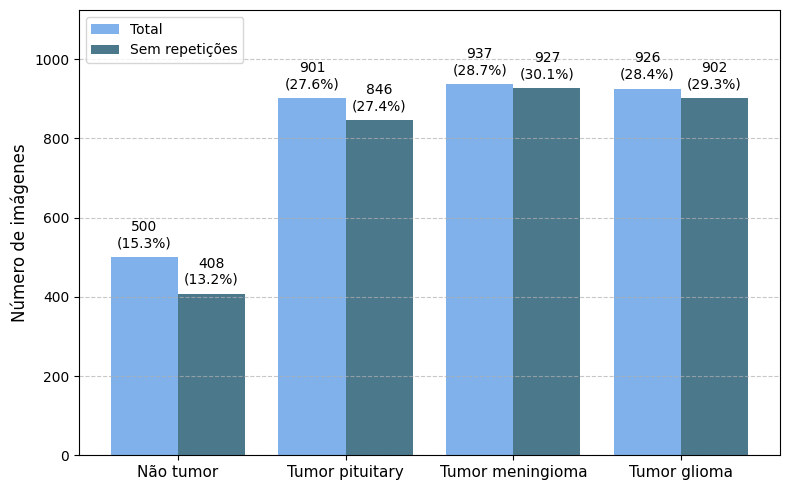

In [ ]:
# Extrair categorias e valores.
categorias = list(conteo_total.keys())
valores_total = np.array(list(conteo_total.values()))
valores_novo = np.array(list(conteo_total_novo.values()))

# Calcular proporções.
total_total = valores_total.sum()
total_novo = valores_novo.sum()
proporciones_total = valores_total / total_total * 100
proporciones_novo = valores_novo / total_novo * 100

# Criar gráfico de barras.
x = np.arange(len(categorias))       # Posição das categorias
width = 0.4                          # Largura das barras

fig, ax = plt.subplots(figsize=(8, 5))
barras1 = ax.bar(x - width/2, valores_total, width, label='Total', color='#4A90E2', alpha=0.7)
barras2 = ax.bar(x + width/2, valores_novo, width, label='Sem repetições', color='#003f5c', alpha=0.7)

# Adicionar os valores e proporções acima das barras
for i, barra in enumerate(barras1):
    valor = int(barra.get_height())
    proporcion = proporciones_total[i]
    ax.annotate(f'{valor}\n({proporcion:.1f}%)',
                xy=(barra.get_x() + barra.get_width() / 2, barra.get_height()),
                xytext=(0, 5),   # Deslocamento
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

for i, barra in enumerate(barras2):
    valor = int(barra.get_height())
    proporcion = proporciones_novo[i]
    ax.annotate(f'{valor}\n({proporcion:.1f}%)',
                xy=(barra.get_x() + barra.get_width() / 2, barra.get_height()),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

ax.set_title('', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(categorias, fontsize=11)
ax.set_ylabel('Número de imágenes', fontsize=12)
ax.set_ylim(0, valores_total.max() * 1.2)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(loc='upper left', fontsize=10, frameon=True)
fig.patch.set_facecolor('white')

plt.tight_layout()
# Salvar a imagem.
plt.savefig('/content/contagem.png', bbox_inches='tight')
plt.show()

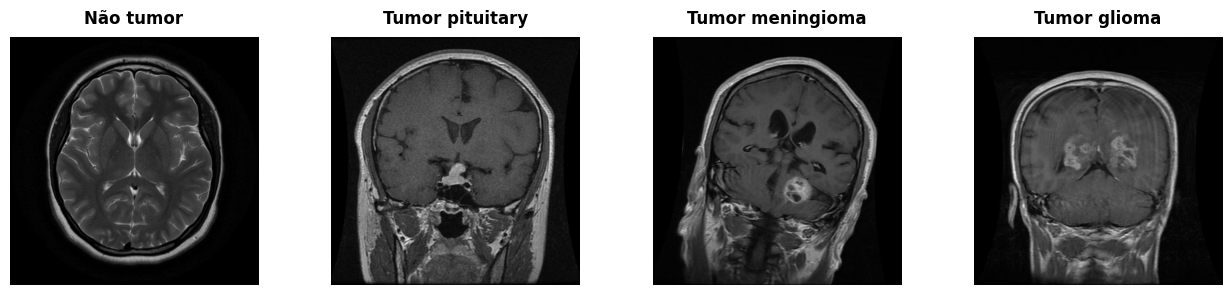

In [ ]:
##  Ver um exemplo por classe

classes = ['Não tumor','Tumor pituitary', 'Tumor meningioma','Tumor glioma']

import matplotlib.pyplot as plt

def show_examples(X_data, Y_data, classes, specific_examples):
    num_classes = len(classes)

    #  Criar subgráficos em uma linha horizontal
    fig, axs = plt.subplots(1, num_classes, figsize=(13, 3))  # 1 fila, num_classes columnas

    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(Y_data) if label == i]

        # Obter o índice específico para cada classe a partir do dicionário
        example_index = specific_examples.get(class_name, 0)  # 0 como valor padrão

        axs[i].set_title(class_name, fontsize=12, pad=10, fontweight='bold')

        # Mostrar a imagem selecionada
        img = X_data[class_indices[example_index]]  # Usamos o índice de exemplo específico
        axs[i].imshow(img)
        axs[i].axis('off')

    plt.tight_layout()

    plt.savefig('/content/examples.png', bbox_inches='tight')
    plt.show()

#  Dicionário com os índices específicos para cada classe
specific_examples = {
    'Não tumor': 10,          # Imagen 1 de la clase 'Não tumor'
    'Tumor pituitary': 3,    # Imagen 3 de la clase 'pituitary_tumor'
    'Tumor meningioma': 1,   # Imagen 2 de la clase 'meningioma_tumor'
    'Tumor glioma': 1        # Imagen 2 de la clase 'glioma_tumor'
}

show_examples(X_train, Y_train, classes, specific_examples)

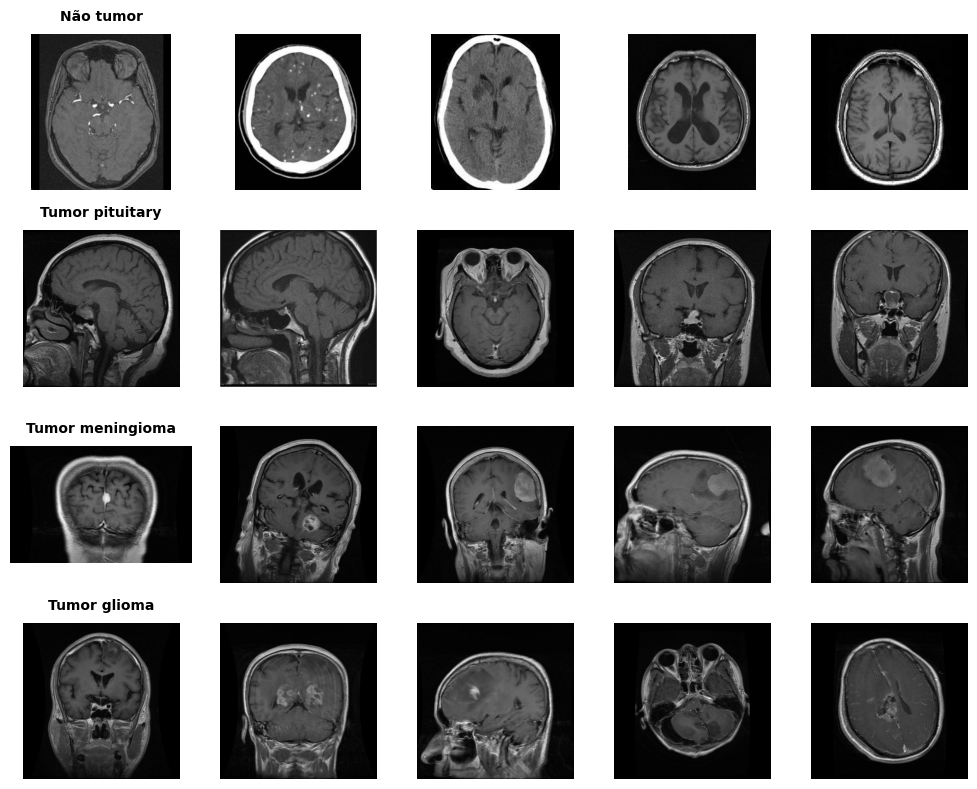

In [ ]:
## Ver mais examples
def show_examples2(X_data, Y_data, classes, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 8))

    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(Y_data) if label == i]
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')
        for j in range(num_examples):
                img = X_data[class_indices[j]]
                axs[i, j].imshow(img)
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Afficher des exemples d'images pour chaque classe
show_examples2(X_train, Y_train, classes)

In [ ]:
# Tamanhos das imagens mais frequentes
train_data_shapes = []
for img in X_train:
  train_data_shapes.append(img.shape)
# Contar as ocorrências para cada tamanho
shape_counts = {}
for shape in train_data_shapes:
  if shape not in shape_counts:
    shape_counts[shape] = 0
  shape_counts[shape] += 1
# Ordenar os tamanhos por número
sorted_shapes = sorted(shape_counts.items(), key=lambda x: x[1], reverse=True)
# Exibir os tamanhos mais frequentes
print("Tamanhos de imagens mais frequentes:")
for shape, count in sorted_shapes[:3]:
  print(f"- {shape}: {count}")

Tamanhos de imagens mais frequentes:
- (512, 512, 3): 2302
- (236, 236, 3): 52
- (225, 225, 3): 37


### **Pré-processamento de dados**

O pré-processamento é uma etapa essencial para preparar os dados antes de utilizá-los em modelos de aprendizado de máquina ou análise. Neste caso se inclui as seguintes etapas:

**Remover bordas desnecessárias:** Eliminar áreas irrelevantes da imagem, focando apenas na região de interesse.

**Redimensionar:** Ajustar as dimensões da imagem para um tamanho consistente.
Converter para escala de cinza: Reduzir a complexidade ao trabalhar com um único canal em vez de três (como no formato RGB).

**Normalizar:** Escalar os valores de pixel para um intervalo padronizado, entre 0 e 1, melhorando a performance do modelo.

**Aumentar os dados:** Gerar novas amostras a partir das existentes (como rotações ou espelhamentos) para enriquecer o conjunto de treinamento.

In [ ]:
# Função que permite recortar uma imagem

def crop_image(image):
    # Converter a imagem em tons de cinza
    if len(image.shape) == 3:  # Verifica se a imagem está no formato BGR
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:  # A imagem já está em tons de cinza.
        gray = image.copy()

    # Aplicar limiar na imagem
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    # Procurar os contornos na imagem
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #  Encontrar o maior contorno
    largest_contour = max(contours, key=cv2.contourArea)

    # Recorte a imagem no maior contorno
    cropped_image = image[cv2.boundingRect(largest_contour)[1]:cv2.boundingRect(largest_contour)[1] + cv2.boundingRect(largest_contour)[3], cv2.boundingRect(largest_contour)[0]:cv2.boundingRect(largest_contour)[0] + cv2.boundingRect(largest_contour)[2]]

    return cropped_image

In [ ]:
# Recortar todas as imagens.
def Aparar_bordas(train_data):
  processed_data = []
  for img in tqdm(train_data):

    cropped_img = crop_image(img)   # Aplicar o recorte
    processed_data.append(cropped_img)

  return processed_data

with tf.device('/GPU:0'):

    X_train_sembordas = Aparar_bordas(X_train)

100%|██████████| 3083/3083 [00:02<00:00, 1230.80it/s]


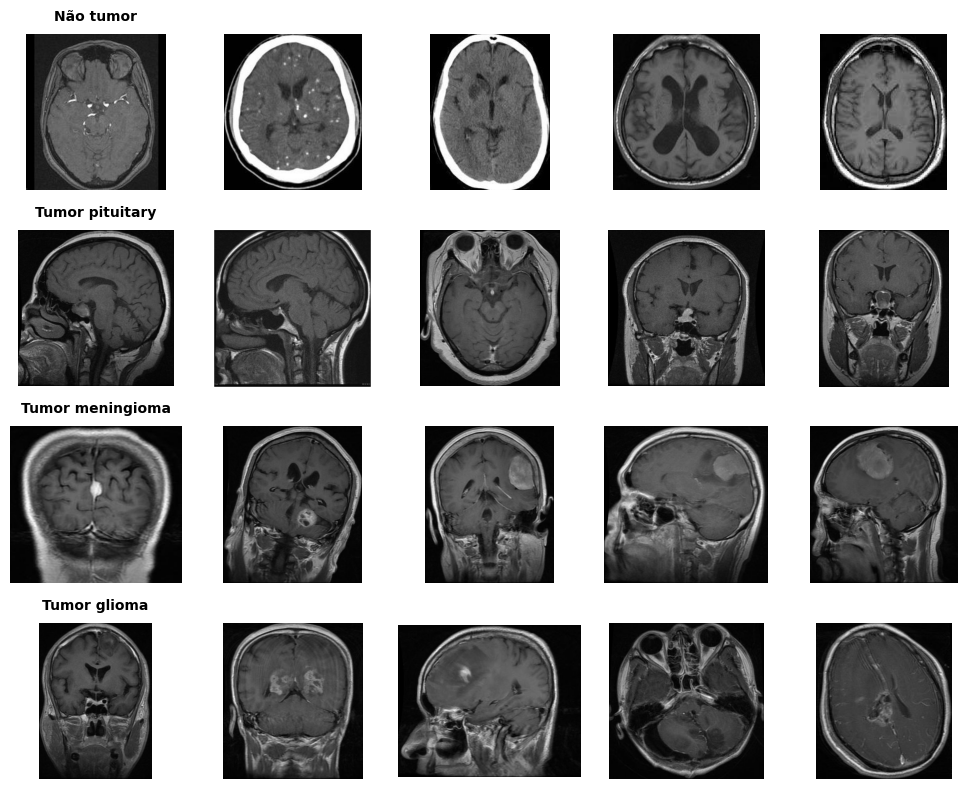

In [ ]:
# Ver exemplos após remover bordas desnecessárias

show_examples2(X_train_sembordas, Y_train, classes)

In [ ]:
# Função para redimensionar imagens
def resize_images(images, target_size=(225, 225)):
    resized_images = []
    for img in images:
        img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
        resized_img = tf.image.resize(img_tensor, target_size)  # Redimensionar a imagem para o tamanho desejado
        resized_images.append(resized_img)
    return np.array(resized_images)

In [ ]:
# Redimensione todas as imagens, tanto a inicial: X_train quanto as do conjunto sem borda: X_train_sembordas

X_train_normal = resize_images(X_train)
X_train_sembordas = resize_images(X_train_sembordas)

# Conferir
print("Nova forma de imagens X_train_normal:", X_train_normal.shape)
print("Nova forma de imagens X_train_sembordas:", X_train_sembordas.shape)

Nova forma de imagens X_train_normal: (3083, 225, 225, 3)
Nova forma de imagens X_train_sembordas: (3083, 225, 225, 3)


In [ ]:
# Converter para escala de cinza mantendo a dimensão do canal único (225, 225, 1).
X_train_normal = X_train_normal.mean(axis=-1, keepdims=True)

print("Nueva forma de las imágenes:", X_train_normal.shape)

Nueva forma de las imágenes: (3083, 225, 225, 1)


In [ ]:
# Converter para escala de cinza mantendo a dimensão do canal único (225, 225, 1).
X_train_sembordas = X_train_sembordas.mean(axis=-1, keepdims=True)

print("Nueva forma de las imágenes:", X_train_sembordas.shape)

Nueva forma de las imágenes: (3083, 225, 225, 1)


In [ ]:
# Normalizar
X_train_normal = X_train_normal.astype('float32') / 255.0

## Para identificar min y maximo

print(f"O mínimo é: {X_train_normal.min()}")
print(f"O máximo é: {X_train_normal.max()}")

O mínimo é: 0.0
O máximo é: 1.0


In [ ]:
# Normalizar
X_train_sembordas = X_train_sembordas.astype('float32') / 255.0

## Para identificar min y maximo

print(f"O mínimo é: {X_train_sembordas.min()}")
print(f"O máximo é: {X_train_sembordas.max()}")

O mínimo é: 0.0
O máximo é: 1.0


Conjunto 1:


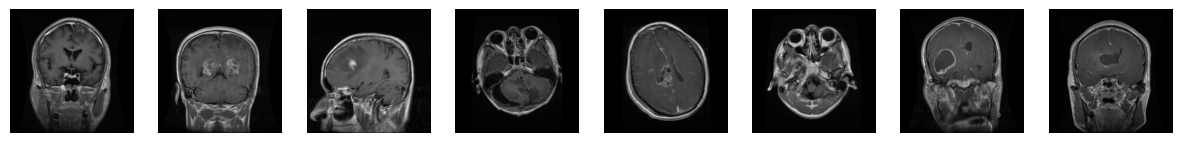

In [ ]:
# Função para exibir imagens em tons de cinza
def plot_grayscale_images(images, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        # Mostrar la imagen en escala de grises
        plt.imshow(images[i, :, :, 0], cmap='gray')  # Selecciona el canal único
        plt.axis('off')
        plt.savefig('/content/preprocesadas.png', bbox_inches='tight')
    plt.show()

# Mostrar algumas imagens convertidas do conjunto 1
print("Conjunto 1:")
plot_grayscale_images(X_train_normal, num_images=8)

Conjunto 2:


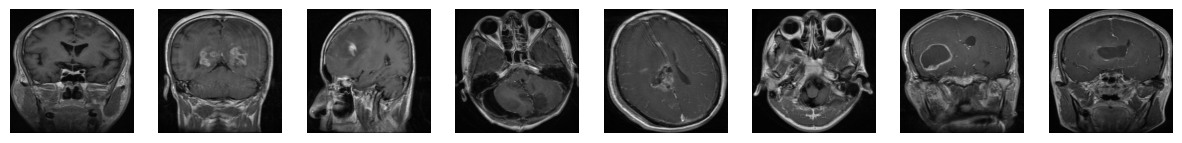

In [ ]:
# Mostrar algumas imagens convertidas do conjunto 2
print("Conjunto 2:")
plot_grayscale_images(X_train_sembordas, num_images=8)

In [ ]:
# Reorganizamos aleatoriamente cada conjunto de dados, preservando a correspondência com as etiquetas originais de Y_train.

X_train_normal, Y_train1 = shuffle(X_train_normal, Y_train, random_state=68)
X_train_sembordas, Y_train2 = shuffle(X_train_sembordas, Y_train, random_state=68)

In [ ]:
print(Y_train1)

[0, 2, 3, 1, 2, 2, 0, 0, 2, 2, 3, 1, 1, 2, 2, 1, 0, 2, 2, 3, 0, 1, 1, 2, 2, 1, 3, 3, 2, 0, 1, 2, 3, 2, 2, 0, 3, 0, 2, 3, 2, 0, 2, 2, 3, 3, 2, 3, 3, 3, 0, 3, 3, 2, 1, 3, 0, 0, 3, 2, 3, 3, 1, 0, 2, 2, 1, 3, 1, 1, 1, 3, 2, 2, 0, 1, 1, 1, 2, 1, 1, 3, 1, 3, 3, 1, 1, 2, 2, 3, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 3, 0, 2, 3, 2, 1, 2, 2, 0, 3, 2, 2, 0, 2, 0, 0, 2, 2, 2, 1, 3, 3, 3, 2, 2, 3, 2, 1, 2, 3, 0, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 3, 1, 0, 3, 3, 2, 1, 1, 3, 2, 3, 0, 3, 3, 2, 0, 1, 1, 3, 3, 3, 3, 2, 3, 2, 3, 2, 1, 3, 2, 3, 2, 3, 2, 2, 2, 1, 0, 1, 3, 1, 2, 1, 3, 0, 2, 2, 0, 0, 0, 3, 0, 0, 3, 0, 2, 2, 3, 2, 2, 0, 0, 3, 1, 3, 0, 2, 2, 1, 0, 1, 3, 3, 2, 2, 1, 2, 3, 3, 2, 3, 2, 3, 2, 1, 0, 2, 2, 2, 1, 2, 2, 0, 3, 2, 1, 3, 2, 2, 1, 1, 2, 3, 1, 3, 3, 0, 1, 0, 1, 2, 1, 1, 0, 2, 3, 2, 1, 3, 0, 1, 0, 0, 2, 3, 3, 3, 2, 3, 1, 1, 3, 3, 1, 3, 3, 2, 3, 0, 1, 3, 1, 2, 0, 2, 2, 2, 3, 0, 2, 2, 2, 1, 2, 3, 3, 2, 3, 1, 0, 2, 2, 3, 1, 2, 3, 2, 1, 0, 2, 3, 2, 3, 0, 2, 2, 3, 3, 1, 1, 2, 1, 2, 3, 3, 1, 2, 2, 2, 

In [ ]:
print(Y_train2)

[0, 2, 3, 1, 2, 2, 0, 0, 2, 2, 3, 1, 1, 2, 2, 1, 0, 2, 2, 3, 0, 1, 1, 2, 2, 1, 3, 3, 2, 0, 1, 2, 3, 2, 2, 0, 3, 0, 2, 3, 2, 0, 2, 2, 3, 3, 2, 3, 3, 3, 0, 3, 3, 2, 1, 3, 0, 0, 3, 2, 3, 3, 1, 0, 2, 2, 1, 3, 1, 1, 1, 3, 2, 2, 0, 1, 1, 1, 2, 1, 1, 3, 1, 3, 3, 1, 1, 2, 2, 3, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 3, 0, 2, 3, 2, 1, 2, 2, 0, 3, 2, 2, 0, 2, 0, 0, 2, 2, 2, 1, 3, 3, 3, 2, 2, 3, 2, 1, 2, 3, 0, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 3, 1, 0, 3, 3, 2, 1, 1, 3, 2, 3, 0, 3, 3, 2, 0, 1, 1, 3, 3, 3, 3, 2, 3, 2, 3, 2, 1, 3, 2, 3, 2, 3, 2, 2, 2, 1, 0, 1, 3, 1, 2, 1, 3, 0, 2, 2, 0, 0, 0, 3, 0, 0, 3, 0, 2, 2, 3, 2, 2, 0, 0, 3, 1, 3, 0, 2, 2, 1, 0, 1, 3, 3, 2, 2, 1, 2, 3, 3, 2, 3, 2, 3, 2, 1, 0, 2, 2, 2, 1, 2, 2, 0, 3, 2, 1, 3, 2, 2, 1, 1, 2, 3, 1, 3, 3, 0, 1, 0, 1, 2, 1, 1, 0, 2, 3, 2, 1, 3, 0, 1, 0, 0, 2, 3, 3, 3, 2, 3, 1, 1, 3, 3, 1, 3, 3, 2, 3, 0, 1, 3, 1, 2, 0, 2, 2, 2, 3, 0, 2, 2, 2, 1, 2, 3, 3, 2, 3, 1, 0, 2, 2, 3, 1, 2, 3, 2, 1, 0, 2, 3, 2, 3, 0, 2, 2, 3, 3, 1, 1, 2, 1, 2, 3, 3, 1, 2, 2, 2, 

In [ ]:
# Converter Y_train para uma série do pandas
Y_train1 = pd.Series(Y_train1)
Y_train2 = pd.Series(Y_train2)

# Converter para categorias e obter os códigos numéricos
Y_train1 = Y_train1.astype('category').cat.codes
Y_train2 = Y_train2.astype('category').cat.codes

# Verificar a transformação
print(Y_train1.head(10))  # Primeras etiquetas categorizadas
print("Categorias atribuídas:", Y_train1.astype('category').cat.categories)

0    0
1    2
2    3
3    1
4    2
5    2
6    0
7    0
8    2
9    2
dtype: int8
Categorias atribuídas: Index([0, 1, 2, 3], dtype='int8')


In [ ]:
# Dividir o conjunto de dados em treino e teste
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train_normal, Y_train1, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_sembordas, Y_train2, test_size=0.2, random_state=42)

In [ ]:
X_train1.shape

(2466, 225, 225, 1)

In [ ]:
X_train2.shape

(2466, 225, 225, 1)

In [ ]:
y_train1.value_counts()

,count
2,742
3,713
1,676
0,335


In [ ]:
y_train2.value_counts()

,count
2,742
3,713
1,676
0,335


Realizou-se a geração de novas instâncias a partir de imagens existentes, aplicando transformações como rotações aleatórias, inversão horizontal e zoom. Essa técnica, conhecida como *data augmentation*, amplia o conjunto de treinamento e contribui para a melhoria da robustez e generalização do modelo.

In [ ]:
# Configurar o gerador de dados com aumento
datagen = ImageDataGenerator(
    rotation_range=40,        # Rotações aleatórias de até 40 graus
    width_shift_range=0,      # Deslocamentos horizontais aleatórios
    height_shift_range=0,     # Deslocamentos verticais aleatórios
    shear_range=0.2,          # Transformações de cisalhamento (shear)
    zoom_range=0.02,          # Zoom aleatório
    horizontal_flip=True,     # Inversão horizontal aleatória
    fill_mode='nearest'       # Preenchimento de bordas com 'nearest'
)

# Selecionar aleatoriamente 100 imagens e suas etiquetas
num_aumentos = 150
indices_aleatorios = np.random.choice(len(X_train2), size=num_aumentos, replace=False)
imagenes_seleccionadas = X_train2[indices_aleatorios]
etiquetas_seleccionadas = np.array(y_train2)[indices_aleatorios]  #  Etiquetas correspondentes

# Gerar imagens aumentadas
imagenes_aumentadas = []
for img in imagenes_seleccionadas:
    img = img[np.newaxis, ...]  # Expandir dimensões para usar com o gerador
    aug_iter = datagen.flow(img, batch_size=1)  # Gerar uma imagem por vez
    augmented_image = next(aug_iter)[0]  # Obter a imagem aumentada
    imagenes_aumentadas.append(augmented_image)

# Converter para arrays do NumPy
imagenes_aumentadas = np.array(imagenes_aumentadas)

# Concatenar com o conjunto original de dados e etiquetas
X_train2_aumentado = np.concatenate([X_train2, imagenes_aumentadas], axis=0)
y_train2_aumentado = np.concatenate([y_train2, etiquetas_seleccionadas], axis=0)

# Verificar as dimensões finais
print(f"Dimensões de X_train2: {X_train2.shape}")
print(f"Dimensões de X_train2_aumentado: {X_train2_aumentado.shape}")
print(f"Dimensões de y_train2: {len(y_train2)}")
print(f"Dimensões de y_train2_aumentado: {len(y_train2_aumentado)}")

Dimensões de X_train2: (2466, 225, 225, 1)
Dimensões de X_train2_aumentado: (2616, 225, 225, 1)
Dimensões de y_train2: 2466
Dimensões de y_train2_aumentado: 2616


In [ ]:
y_train2_aumentado = pd.Series(y_train2_aumentado)

In [ ]:
y_train2_aumentado.value_counts()

,count
2,787
3,761
1,719
0,349


### **Treinamento e avaliação do modelo**

In [ ]:
#  Arquitetura do modelo
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(225, 225, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model1 = create_model()
model2 = create_model()
model3 = create_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 223, 223, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      37,749,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,434,308 (146.62 MB)

 Trainable params: 38,434,308 (146.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenamiento del modelo
with tf.device('/GPU:0'):
  history1 = model1.fit(X_train1, y_train1, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 775ms/step - accuracy: 0.4116 - loss: 2.3670 - val_accuracy: 0.4312 - val_loss: 1.2469
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.4957 - loss: 1.1171 - val_accuracy: 0.5061 - val_loss: 1.0714
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.6031 - loss: 0.9060 - val_accuracy: 0.5344 - val_loss: 1.0999
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.6397 - loss: 0.8261 - val_accuracy: 0.5425 - val_loss: 1.0308
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.6988 - loss: 0.7140 - val_accuracy: 0.6498 - val_loss: 0.7833
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.7253 - loss: 0.6906 - val_accuracy: 0.6235 - val_loss: 0.8458
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.7970 - loss: 0.5315 - val_accuracy: 0.6073 - val_loss: 0.9011
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.8336 - loss: 0.4394 - val_accuracy: 0

In [ ]:
# Evaluación en el conjunto de prueba
loss1, accuracy1 = model1.evaluate(X_test1, y_test1)
print(f"Acurácia no teste: {accuracy1:.2f}")
print(f"Loss no teste: {loss1:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.8090 - loss: 0.6720
Acurácia no teste: 0.81
Loss no teste: 0.69


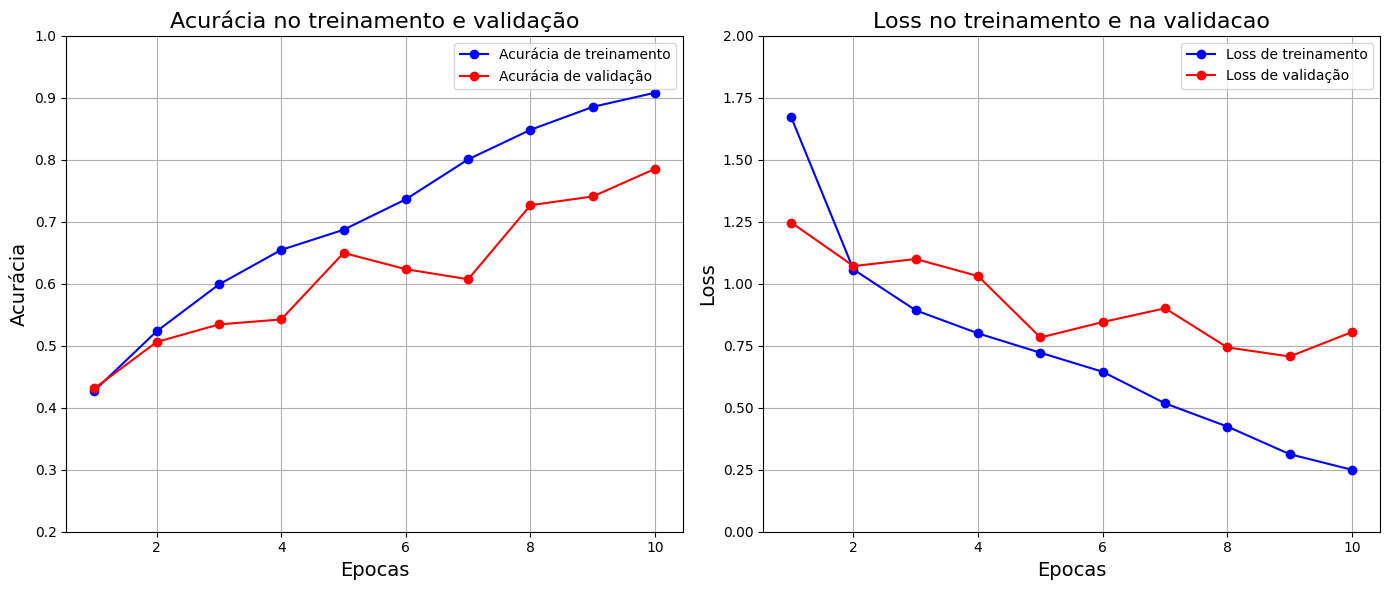

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'o-', color='blue', label='Acurácia de treinamento')
plt.plot(epochs, val_acc, 'o-', color='red', label='Acurácia de validação')
plt.title('Acurácia no treinamento e validação', fontsize=16)
plt.xlabel('Epocas', fontsize=14)
plt.ylabel('Acurácia', fontsize=14)
plt.ylim(0.2, 1)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', color='blue', label='Loss de treinamento')
plt.plot(epochs, val_loss, 'o-', color='red', label='Loss de validação')
plt.title('Loss no treinamento e na validacao', fontsize=16)
plt.xlabel('Epocas', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.ylim(0, 2)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/content/model1.png', bbox_inches='tight')
plt.show()

In [ ]:
history2 = model2.fit(X_train2, y_train2, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.8962 - loss: 0.2841 - val_accuracy: 0.8097 - val_loss: 0.6088
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9302 - loss: 0.1771 - val_accuracy: 0.7874 - val_loss: 0.6525
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9297 - loss: 0.1818 - val_accuracy: 0.8117 - val_loss: 0.5902
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9435 - loss: 0.1571 - val_accuracy: 0.8138 - val_loss: 0.6683
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9599 - loss: 0.1110 - val_accuracy: 0.7915 - val_loss: 0.7094
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9518 - loss: 0.1286 - val_accuracy: 0.8057 - val_loss: 0.7177
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9577 - loss: 0.1070 - val_accuracy: 0.8381 - val_loss: 0.6818
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9923 - loss: 0.0363 - val_accuracy: 0.

In [ ]:
# Evaluación en el conjunto de prueba
loss2, accuracy2 = model2.evaluate(X_test2, y_test2)
print(f"Acurácia no teste: {accuracy2:.2f}")
print(f"Loss no teste: {loss2:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8710 - loss: 0.4876
Acurácia no teste: 0.88
Loss no teste: 0.49


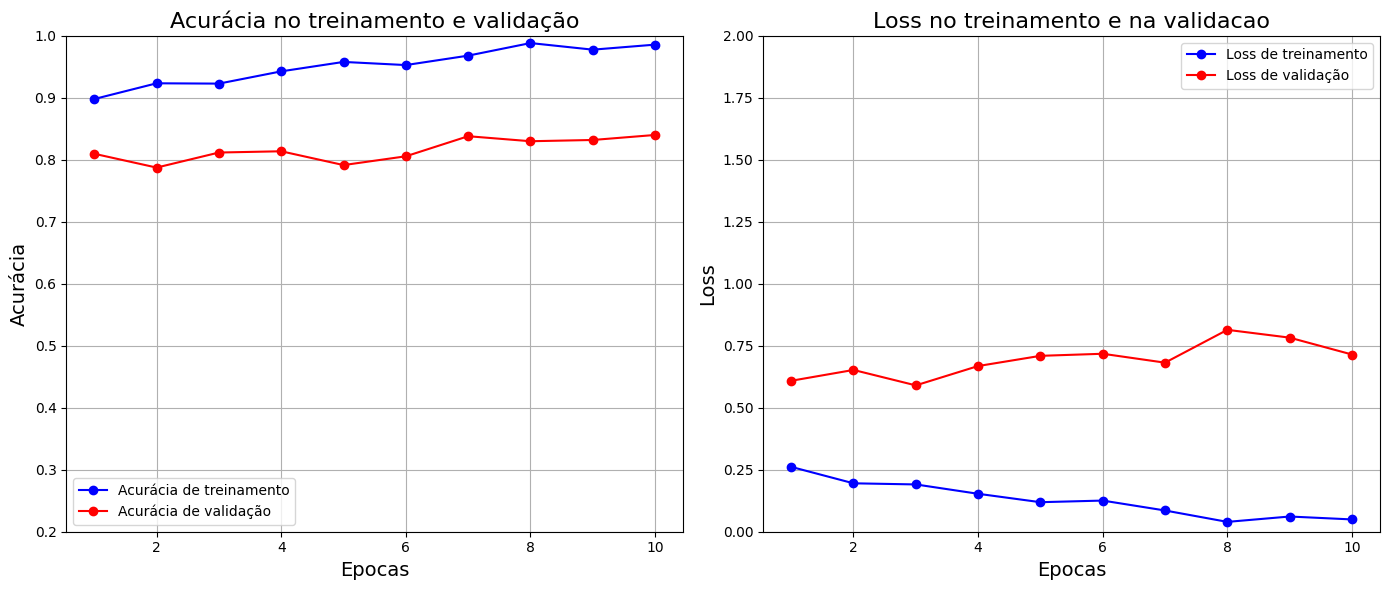

In [ ]:
import matplotlib.pyplot as plt

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'o-', color='blue', label='Acurácia de treinamento')
plt.plot(epochs, val_acc, 'o-', color='red', label='Acurácia de validação')
plt.title('Acurácia no treinamento e validação', fontsize=16)
plt.xlabel('Epocas', fontsize=14)
plt.ylabel('Acurácia', fontsize=14)
plt.legend()
plt.ylim(0.2, 1)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', color='blue', label='Loss de treinamento')
plt.plot(epochs, val_loss, 'o-', color='red', label='Loss de validação')
plt.title('Loss no treinamento e na validacao', fontsize=16)
plt.xlabel('Epocas', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.ylim(0, 2)
plt.grid(True)

plt.tight_layout()
plt.savefig('/content/model2.png', bbox_inches='tight')
plt.show()

In [ ]:
history3 = model3.fit(X_train2_aumentado, y_train2_aumentado, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.8649 - loss: 0.3374 - val_accuracy: 0.7557 - val_loss: 0.7577
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9119 - loss: 0.2436 - val_accuracy: 0.7118 - val_loss: 0.9299
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9372 - loss: 0.1736 - val_accuracy: 0.7691 - val_loss: 0.9560
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9484 - loss: 0.1506 - val_accuracy: 0.7710 - val_loss: 0.8287
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9613 - loss: 0.1276 - val_accuracy: 0.7748 - val_loss: 0.8868
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9638 - loss: 0.1097 - val_accuracy: 0.7576 - val_loss: 0.9325
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9702 - loss: 0.0836 - val_accuracy: 0.7882 - val_loss: 1.0172
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9808 - loss: 0.0540 - val_accuracy: 0.

In [ ]:
# Evaluación en el conjunto de prueba
loss3, accuracy3 = model3.evaluate(X_test2, y_test2)
print(f"Acurácia no teste: {accuracy3:.2f}")
print(f"Loss no teste: {loss3:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8662 - loss: 0.5165
Acurácia no teste: 0.86
Loss no teste: 0.59


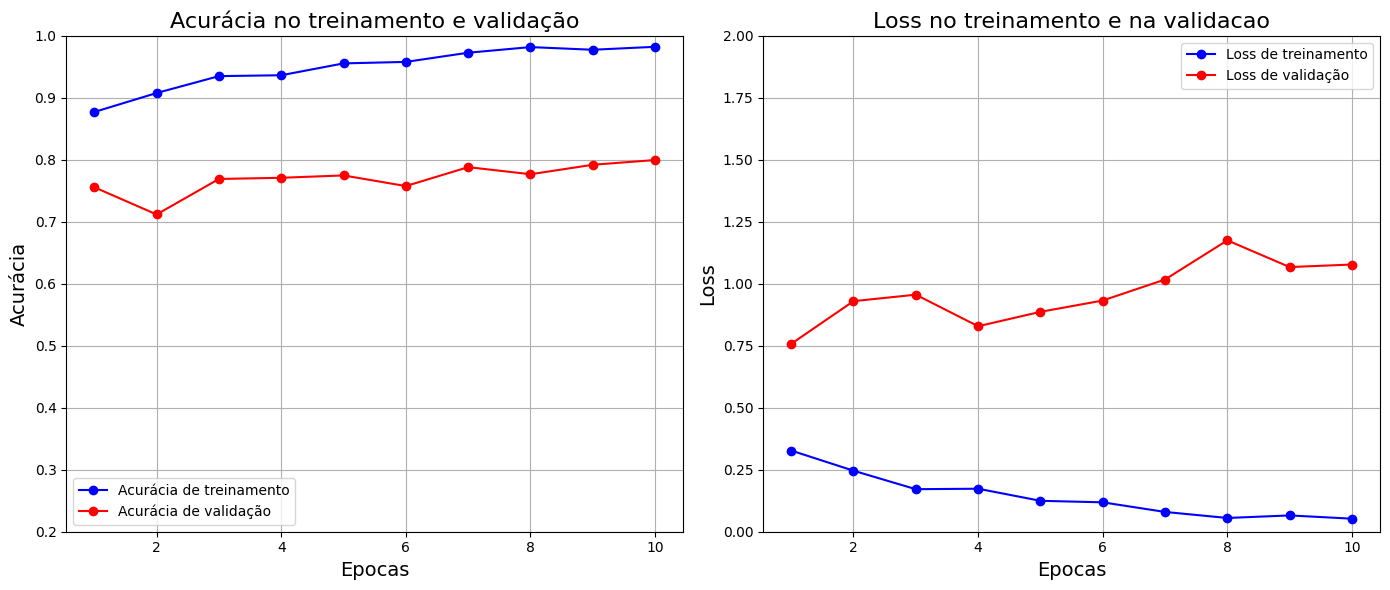

In [ ]:
import matplotlib.pyplot as plt

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'o-', color='blue', label='Acurácia de treinamento')
plt.plot(epochs, val_acc, 'o-', color='red', label='Acurácia de validação')
plt.title('Acurácia no treinamento e validação', fontsize=16)
plt.xlabel('Epocas', fontsize=14)
plt.ylabel('Acurácia', fontsize=14)
plt.legend()
plt.ylim(0.2, 1)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', color='blue', label='Loss de treinamento')
plt.plot(epochs, val_loss, 'o-', color='red', label='Loss de validação')
plt.title('Loss no treinamento e na validacao', fontsize=16)
plt.xlabel('Epocas', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.ylim(0, 2)
plt.grid(True)

plt.tight_layout()
plt.savefig('/content/model3.png', bbox_inches='tight')
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


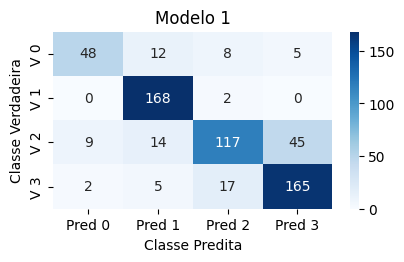

In [ ]:
# Predicciones
y_pred1 = model1.predict(X_test1)
y_pred_classes = model1.predict(X_test1).argmax(axis=1)

# Gerar a matriz de confusão
conf_matrix1 = confusion_matrix(y_test1, y_pred_classes)

# Converter para DataFrame para melhor visualização
conf_matrix_df1 = pd.DataFrame(conf_matrix1, index=[f"V {i}" for i in range(conf_matrix1.shape[0])],
                              columns=[f"Pred {i}" for i in range(conf_matrix1.shape[1])])

# Visualizar a matriz de confusão com um mapa de calor
plt.figure(figsize=(4.5, 2.3))
sns.heatmap(conf_matrix_df1, annot=True, fmt='d', cmap='Blues')
plt.title('Modelo 1')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.savefig('/content/model1MC.png', bbox_inches='tight')
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


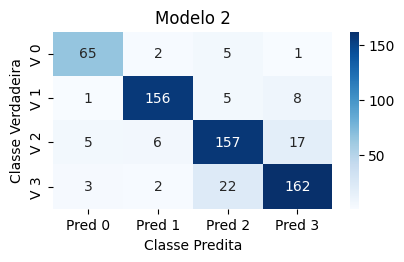

In [ ]:
# Predicciones
y_pred2 = model2.predict(X_test2)
y_pred_classes2 = model2.predict(X_test2).argmax(axis=1)

# Gerar a matriz de confusão
conf_matrix2 = confusion_matrix(y_test2, y_pred_classes2)

# Converter para DataFrame para melhor visualização
conf_matrix_df2 = pd.DataFrame(conf_matrix2, index=[f"V {i}" for i in range(conf_matrix2.shape[0])],
                              columns=[f"Pred {i}" for i in range(conf_matrix2.shape[1])])

# Visualizar a matriz de confusão com um mapa de calor
plt.figure(figsize=(4.5, 2.3))
sns.heatmap(conf_matrix_df2, annot=True, fmt='d', cmap='Blues')
plt.title('Modelo 2')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.savefig('/content/model2MC.png', bbox_inches='tight')
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


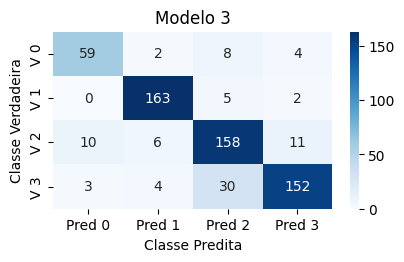

In [ ]:
# Predicciones
y_pred3 = model3.predict(X_test2)
y_pred_classes3 = model3.predict(X_test2).argmax(axis=1)

# Gerar a matriz de confusão
conf_matrix3 = confusion_matrix(y_test2, y_pred_classes3)

# Converter para DataFrame para melhor visualização
conf_matrix_df3 = pd.DataFrame(conf_matrix3, index=[f"V {i}" for i in range(conf_matrix3.shape[0])],
                              columns=[f"Pred {i}" for i in range(conf_matrix3.shape[1])])

# Visualizar a matriz de confusão com um mapa de calor
plt.figure(figsize=(4.5, 2.3))
sns.heatmap(conf_matrix_df3, annot=True, fmt='d', cmap='Blues')
plt.title('Modelo 3')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.savefig('/content/model3MC.png', bbox_inches='tight')
plt.show()

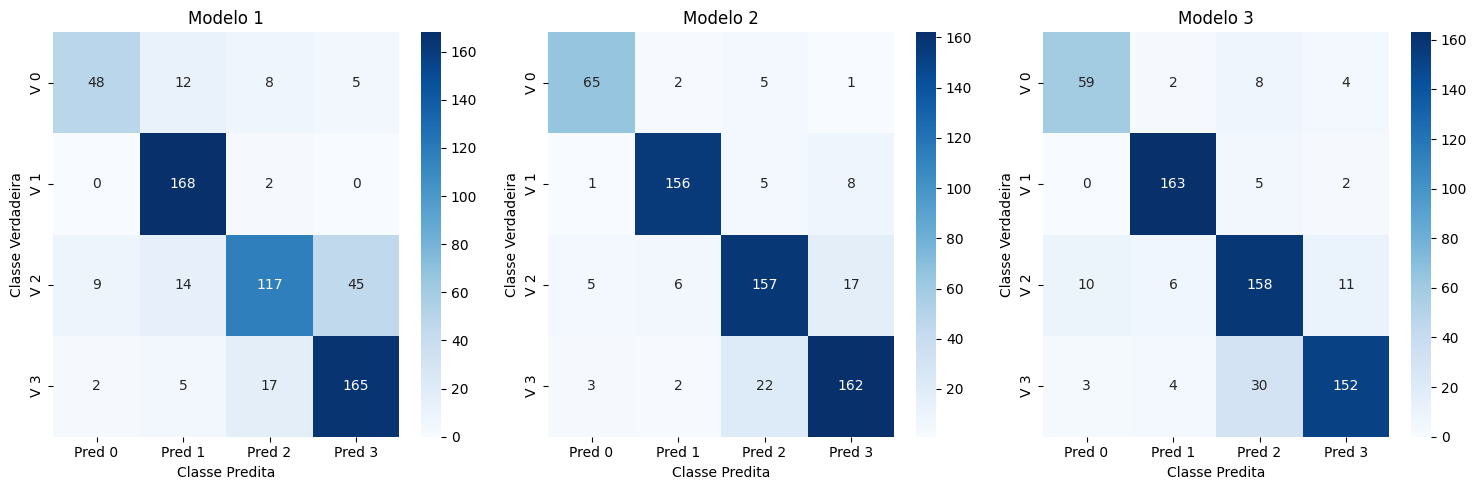

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Crear una figura con tres subplots en una fila
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Modelo 1
sns.heatmap(conf_matrix_df1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Modelo 1')
axes[0].set_xlabel('Classe Predita')
axes[0].set_ylabel('Classe Verdadeira')

# Modelo 2
sns.heatmap(conf_matrix_df2, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Modelo 2')
axes[1].set_xlabel('Classe Predita')
axes[1].set_ylabel('Classe Verdadeira')

# Modelo 3
sns.heatmap(conf_matrix_df3, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Modelo 3')
axes[2].set_xlabel('Classe Predita')
axes[2].set_ylabel('Classe Verdadeira')

# Ajustar los espacios entre subplots
plt.tight_layout()

# Guardar la figura como una sola imagen
plt.savefig('/content/matrices_de_confusion_combined.png', dpi=300, bbox_inches='tight')

# Mostrar la figura
plt.show()


**Desafios enfrentados no desenvolvimento do trabalho**

Durante o desenvolvimento deste trabalho, foram enfrentados diversos desafios que demandaram adaptações e estratégias específicas. O manejo e o pré-processamento do conjunto de dados destacaram-se como uma etapa complexa devido à diversidade das imagens e às diferenças em suas características, o que exigiu cuidado na padronização e na preparação para o treinamento dos modelos. A escolha de uma arquitetura que fosse relativamente adequada também representou um desafio, considerando a necessidade de equilibrar a simplicidade do modelo com a capacidade de capturar padrões relevantes para a classificação.

Além disso, os recursos computacionais apresentaram limitações importantes. Inicialmente, sem o uso de GPU, o treinamento de 10 épocas demorava cerca de 1 hora, o que tornava o processo consideravelmente lento. Posteriormente, foi possível utilizar uma GPU, o que reduziu o tempo total para cerca de 1 minuto para as mesmas 10 épocas, representando uma melhora significativa no tempo de execução. No entanto, após algum tempo, a GPU não pôde mais ser utilizada, pois a memória RAM disponível foi excedida, interrompendo o uso eficiente dos recursos computacionais. Esse contexto evidenciou a importância de recursos adequados para o treinamento de redes neurais e a necessidade de gerenciar cuidadosamente as limitações técnicas durante o desenvolvimento do projeto.